# Machine Learning Project:
# Biometric Gait Recognition
## April 16, 2016
### Math 404
### Instructor:  Jeff Humpherys

## Part 1:  Feature Extraction

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import distributions
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)
%matplotlib inline
pd.set_option('expand_frame_repr', True)
pd.set_option('max_rows',200)

** First, we look at data where the only activity is walking **

In [2]:
accel_data = pd.read_csv("ProjectData.csv")


In [13]:
accel_data.describe()

,ActivityID,PersonID,Samplerate,Ax,Ay,Az,A_tot,JointID
count,4776287.0,4.776287e+06,4.776287e+06,4.776287e+06,4.776287e+06,4.776287e+06,4.776287e+06,4.776287e+06
mean,1.0,9.058953e+00,2.857174e+02,-2.540265e+02,-1.159303e+02,-4.984405e+02,1.267648e+03,5.605895e+01
std,0.0,4.635107e+00,1.641292e+02,7.530663e+02,7.396193e+02,7.375113e+02,6.144494e+02,4.635107e+00
min,1.0,6.000000e+00,5.000000e+01,-1.628800e+04,-1.638200e+04,-1.604000e+04,2.828427e+00,5.300000e+01
25%,1.0,7.000000e+00,5.000000e+01,-7.030000e+02,-5.900000e+02,-1.028000e+03,1.019321e+03,5.400000e+01
50%,1.0,8.000000e+00,4.000000e+02,-8.800000e+01,-7.000000e+01,-5.360000e+02,1.101486e+03,5.500000e+01
75%,1.0,1.000000e+01,4.000000e+02,1.620000e+02,2.580000e+02,-1.100000e+01,1.385228e+03,5.700000e+01
max,1.0,4.700000e+01,4.000000e+02,1.638200e+04,1.524200e+04,1.637600e+04,2.585465e+04,9.400000e+01


In [3]:
joint_data = pd.read_csv("ActivityData.csv")

In [8]:
activity_data = joint_data.groupby("PersonID").get_group(6)
activity_data.describe()

,ActivityID,SessionID,PersonID,DeviceID,Samplerate,TimeDelta,Ax,Ay,Az
count,1.165455e+06,1.165455e+06,1165455.0,1.165455e+06,1.165455e+06,1.165455e+06,1.165455e+06,1.165455e+06,1.165455e+06
mean,2.703363e+00,7.271151e+00,6.0,3.785251e-01,2.675162e+02,1.462222e+03,9.412698e+01,1.049532e+02,-9.181363e+02
std,2.369678e+00,2.910118e+00,0.0,4.850196e-01,1.697569e+02,1.135314e+03,7.385541e+02,4.869467e+02,5.961495e+02
min,1.000000e+00,5.000000e+00,6.0,0.000000e+00,5.000000e+01,9.350000e-01,-1.203400e+04,-7.506000e+03,-1.312600e+04
25%,1.000000e+00,5.000000e+00,6.0,0.000000e+00,5.000000e+01,6.125540e+02,-9.600000e+01,-1.500000e+02,-1.078000e+03
50%,1.000000e+00,5.000000e+00,6.0,0.000000e+00,4.000000e+02,1.224266e+03,-3.200000e+01,3.800000e+01,-1.044000e+03
75%,4.000000e+00,1.100000e+01,6.0,1.000000e+00,4.000000e+02,1.835883e+03,4.320000e+02,2.540000e+02,-7.200000e+02
max,7.000000e+00,1.100000e+01,6.0,1.000000e+00,4.000000e+02,4.617069e+03,7.739000e+03,8.110000e+03,9.320000e+03


In [3]:
def clean_data(data):
    #All columns have same type of activity, so we drop ActivityID
    data.drop(["SessionID", "TimeDelta", "DeviceID"], 1, inplace=True)
    
    #We add a column for the total acceleration at each point
    data['A_tot'] = np.sqrt(data["Ax"]**2 + data["Ay"]**2 + data["Az"]**2)
    
    #Now drop the individual components of acceleration
    data.drop(["Ax",'Ay','Az'], 1, inplace=True)
    
    #Generate a column that corresponds to the person and the activity
    #Note that JointID//47 gives the activity and JointID%47 gives the person
    data["JointID"] = 47*data["ActivityID"] + data["PersonID"]
    
    #Classify slow walk and fast walk as simply "walking"
    #data.replace(to_replace={'ActivityID':{2:1, 3:1}},inplace=True)
    
    #Drop "microwalk" activity values since they don't matter for our classification tests.
    data = data[data.ActivityID<=7]
    return data
    
 

In [4]:
accel_data = clean_data(accel_data)

In [10]:
joint_data = clean_data(joint_data)

In [24]:
rate_groups = accel_data.groupby("Samplerate")
rate_groups.describe()

A_tot  ActivityID        PersonID
Samplerate                                                  
50         count  1559562.000000     1559562  1559562.000000
           mean      1200.243164           1        9.431681
           std        449.274271           0        7.680550
           min         13.601471           1        7.000000
           25%       1061.562528           1        7.000000
           50%       1098.874879           1        7.000000
           75%       1188.943649           1        7.000000
           max       8430.791956           1       47.000000
400        count  3216725.000000     3216725  3216725.000000
           mean      1300.328349           1        8.878244
           std        677.836336           0        1.788830
           min          2.828427           1        6.000000
           25%        987.345937           1        8.000000
           50%       1111.406316           1        9.000000
           75%       1456.848654           1       10.000000
           max      25854.651961           1       11.000000

In [12]:
activity_groups = joint_data.groupby(['ActivityID'])


activity_groups.describe()

A_tot            Ax            Ay            Az  \
ActivityID                                                                 
1          count  4.776287e+06  4.776287e+06  4.776287e+06  4.776287e+06   
           mean   1.267648e+03 -2.540265e+02 -1.159303e+02 -4.984405e+02   
           std    6.144494e+02  7.530663e+02  7.396193e+02  7.375113e+02   
           min    2.828427e+00 -1.628800e+04 -1.638200e+04 -1.604000e+04   
           25%    1.019321e+03 -7.030000e+02 -5.900000e+02 -1.028000e+03   
           50%    1.101486e+03 -8.800000e+01 -7.000000e+01 -5.360000e+02   
           75%    1.385228e+03  1.620000e+02  2.580000e+02 -1.100000e+01   
           max    2.585465e+04  1.638200e+04  1.524200e+04  1.637600e+04   
2          count  8.696190e+05  8.696190e+05  8.696190e+05  8.696190e+05   
           mean   1.233234e+03 -2.340668e+02  2.149340e+02 -6.045686e+02   
           std    5.632443e+02  6.564537e+02  7.896809e+02  5.631130e+02   
           min    1.360147e+01 -8.276000e+03 -6.922000e+03 -5.922000e+03   
           25%    1.011410e+03 -4.230000e+02 -2.710000e+02 -9.920000e+02   
           50%    1.098670e+03 -4.100000e+01  1.920000e+02 -7.560000e+02   
           75%    1.265913e+03  1.460000e+02  6.880000e+02 -2.060000e+02   
           max    1.291883e+04  5.728000e+03  1.280400e+04  6.276000e+03   
3          count  1.857122e+06  1.857122e+06  1.857122e+06  1.857122e+06   
           mean   1.243880e+03 -2.560715e+02 -1.447708e+02 -4.521718e+02   
           std    6.005994e+02  6.715927e+02  7.872188e+02  7.390658e+02   
           min    2.828427e+00 -8.480000e+03 -1.378600e+04 -1.195800e+04   
           25%    9.649843e+02 -6.920000e+02 -6.150000e+02 -9.440000e+02   
           50%    1.102126e+03 -5.300000e+01 -1.880000e+02 -4.940000e+02   
           75%    1.373475e+03  1.730000e+02  2.820000e+02  5.000000e+01   
           max    2.043472e+04  6.508000e+03  1.280400e+04  1.637600e+04   
4          count  2.688653e+06  2.688653e+06  2.688653e+06  2.688653e+06   
           mean   1.286871e+03 -1.578603e+02 -1.604306e+02 -5.165307e+02   
           std    6.599299e+02  7.533479e+02  8.099614e+02  7.419654e+02   
           min    2.828427e+00 -1.628800e+04 -1.638200e+04 -1.604000e+04   
           25%    9.846243e+02 -5.980000e+02 -6.100000e+02 -9.880000e+02   
           50%    1.111585e+03 -4.100000e+01 -1.820000e+02 -5.620000e+02   
           75%    1.424503e+03  2.400000e+02  2.300000e+02 -3.600000e+01   
           max    2.585465e+04  1.638200e+04  1.524200e+04  1.637600e+04   
5          count  1.857122e+06  1.857122e+06  1.857122e+06  1.857122e+06   
           mean   1.243880e+03 -2.560715e+02 -1.447708e+02 -4.521718e+02   
           std    6.005994e+02  6.715927e+02  7.872188e+02  7.390658e+02   
           min    2.828427e+00 -8.480000e+03 -1.378600e+04 -1.195800e+04   
           25%    9.649843e+02 -6.920000e+02 -6.150000e+02 -9.440000e+02   
           50%    1.102126e+03 -5.300000e+01 -1.880000e+02 -4.940000e+02   
           75%    1.373475e+03  1.730000e+02  2.820000e+02  5.000000e+01   
           max    2.043472e+04  6.508000e+03  1.280400e+04  1.637600e+04   
6          count  1.372687e+06  1.372687e+06  1.372687e+06  1.372687e+06   
           mean   1.261283e+03 -1.527031e+02 -7.116265e+00 -6.701345e+02   
           std    6.516956e+02  6.352257e+02  8.270131e+02  6.750038e+02   
           min    1.360147e+01 -8.276000e+03 -1.378600e+04 -1.195800e+04   
           25%    9.683357e+02 -4.000000e+02 -5.100000e+02 -1.058000e+03   
           50%    1.099609e+03 -3.700000e+01 -1.400000e+01 -7.580000e+02   
           75%    1.347180e+03  1.820000e+02  4.640000e+02 -2.340000e+02   
           max    1.724864e+04  6.508000e+03  1.280400e+04  1.021600e+04   
7          count  2.205770e+05  2.205770e+05  2.205770e+05  2.205770e+05   
           mean   1.140919e+03  4.371667e+02  4.751052e+01 -6.878297e+02   
           std    5.483706e+02  5.929245e+02  5.901767e+02  4.858605e+02 

#### Extract Features
Here, we extract features by performing the following:   
1. Normalize the gait of each individual by centering accelerations around 0
2. Calculate the min, max, mean, standard deviation, and histogram distribution of each attribute

In [6]:
def feature_extraction(data, split_var="JointID"):
    #When performing activity classification, we still split our data based on person and activity, but then label based on activity
    if split_var=="ActivityID":
        grouped = data.groupby(["JointID"])
    else:
        grouped = data.groupby([split_var])
    x_s = []
    labels = []
    
    #Calculate histogram bins to use later for features
    lower = data["A_tot"].min()-data["A_tot"].mean()
    upper = data["A_tot"].max()-data["A_tot"].mean()
    histogram_bins = np.linspace(0,1,51)
    #print histogram_bins
    
    
    for user, features in grouped:
        #Get feature attributes on 3 second samples from each individual
        #We assume no overlap between samples
        sample_rate = features["Samplerate"].as_matrix()[0]
        num_samples = features.count().as_matrix()[0]
        N_3_sec = sample_rate*3
        
        #Normalize data by centering each individual at 0. 
        features["A_tot"] -= features["A_tot"].mean()
        
        #Extract as many full samples as we can
        n_extracts = num_samples//N_3_sec
        for i in xrange(n_extracts):
            attributes = []
            
            
            labels.append(features[split_var].as_matrix()[0])

            subset = features[N_3_sec*i:N_3_sec*(i+1)]
            
            attributes.append(subset["A_tot"].mean())
            attributes.append(subset["A_tot"].std())
            attributes.append(subset["A_tot"].max())
            attributes.append(subset["A_tot"].min())
            attributes.append(subset["A_tot"].max() - subset["A_tot"].min())
            
            #Calculate RMS of total acceleration of each sample
            attributes.append(np.sqrt(np.sum(np.square(subset["A_tot"])/N_3_sec)))
            
            #Calculate total number of sign changes in the subset
            attributes.append(np.sum(np.abs((np.sign(subset["A_tot"][:-1]).as_matrix() - np.sign(subset["A_tot"][1:]).as_matrix()/sample_rate)/2)))
            
            
            #Calculate histogram distribution of of samples in dataset
            normed = (subset["A_tot"]-subset.A_tot.min())/(subset.A_tot.max()-subset.A_tot.min())
            for k in np.histogram(normed, bins=histogram_bins)[0]:
                attributes.append(k/sample_rate)
                
            
            x_s.append(attributes)
            #print np.array(attributes)
            #break
        #break
    #print "Labels: ", labels
    #print "Features: ", x_s
    return np.array(labels), np.array(x_s)
        
#labels, feats = feature_extraction()


In [7]:
def split_train_test_data(labels, features):
    #Randomly assigns rows to training and testing data
    
    num_rows = features.shape[0]

    test_rows = np.random.choice(num_rows, size=np.floor(.3*num_rows), replace=False)
    test_features = features[test_rows]
    test_labels = labels[test_rows]
    train_mask = np.ones(num_rows, dtype=bool)
    train_mask[test_rows] = 0
    train_features = features[train_mask]
    train_labels = labels[train_mask]
    return train_labels, train_features, test_labels, test_features


In [74]:
def find_optimal_tree_num(tr_labels, tr_features, te_labels, te_features):
    tree_numbers = []
    for i in xrange(5,501, 5):
        print i
        rf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
        #print tr_features[np.isnan(tr_features).any(axis=1)].shape
        rf.fit(tr_features, tr_labels)
        predicted_labels = rf.predict(te_features)

        #importances = rf.feature_importances_
        #plt.bar(range(len(importances)), importances)
        tree_numbers.append(1.-len(np.where(predicted_labels != te_labels)[0])/te_labels.shape[0])
    plt.plot(range(1, 501, 5), tree_numbers)
    plt.show()

In [157]:
def get_activity_classification_accuracy(predicted_activities, actual_activities):
    activity_tags = {1:"Walking", 2:"Slow Walk", 3:"Fast Walk", 4:"Jogging", 5:"Stair Climbing", \
                     6:"Faking", 7:"Biking"}
    activities, activity_counts = np.unique(actual_activities, return_counts=True)
    misclassified = np.where(predicted_activities!=actual_activities)
    misclassified_activities, misclassified_counts = np.unique(actual_activities[misclassified], \
                                                               return_counts=True)
    activity_count_dict = {activities[i]:activity_counts[i] for i in xrange(len(activities))}
    misclassified_count_dict = {misclassified_activities[i]:misclassified_counts[i] \
                                for i in xrange(len(misclassified_activities))}
    classification_rates = {}
    for i in xrange(1,8):
        if i in misclassified_count_dict:
            classification_rates[activity_tags[i]] = 1-misclassified_count_dict[i]/activity_count_dict[i]
        elif i in activity_count_dict:
            classification_rates[activity_tags[i]] = 1
        else:
            classification_rates[activity_tags[i]] = "Activity not found in data"
            
    print "Classification Rates: "
    for key in classification_rates.keys():
        print key+":", classification_rates[key]
    return classification_rates.keys(), classification_rates.values()

In [158]:
def random_forest_model(tr_labels, tr_features, te_labels, te_features, n_runs=10, plot=True, model_type="Person"):
    correctly_classified = np.zeros(n_runs)
    run_importances = np.zeros((n_runs,8))
    activity_classification = np.zeros(7)
    
    for i in xrange(n_runs):
        print i+1
        #Train a random forest and predict the number correct
        rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        rf.fit(tr_features, tr_labels)
        predicted_labels = rf.predict(te_features)
        correct_proportion = 1.-len(np.where(predicted_labels != te_labels)[0])/te_labels.shape[0]
        #print "Proportion correctly classified: ", correct_proportion
        correctly_classified[i] = correct_proportion
        
        #Return activity classification rates when we run our activity model
        if model_type=="Activity":
            classification_labels, classification_rates = get_activity_classification_accuracy(predicted_labels, te_labels)
            #print classification_labels
            #print classification_rates
            activity_classification += classification_rates
            
            
        #Calculate feature importances
        feat_importances = rf.feature_importances_
        hist_importances = np.sum(feat_importances[7:])
        importances = np.empty(8)
        importances[:7] = feat_importances[:7]
        importances[7] = hist_importances
        run_importances[i,:] = importances
    
    activity_classification /= n_runs
    correct = np.mean(correctly_classified)
    final_importances = np.mean(run_importances, axis=0)
    print "Proportion correctly classified: ", correct
    
    if model_type=="Activity":
        pos = np.arange(len(activity_classification))+.5
        plt.xlabel("Proportion Correctly Classified")
        mycolors = ['b', 'g', 'r', '#FFA500','#800080','c', '#FF7F50']
        act_series = pd.Series(activity_classification, index=classification_labels)
        act_series.plot(kind='barh', color=mycolors)
        plt.show()
    
    if plot==True:
        pos = np.arange(len(final_importances))+.5
        #plt.barh(pos, importances, color='c')
        plt.xlabel("Feature Importance")
        labels = ["Mean", "Standard Deviation",'Min', 'Max',"Value Range","Root Mean Square","Sign Changes","Histogram Distribution"]
        s = pd.Series(final_importances, index=labels)
        mycolors = ['b', 'g', 'r', '#FFA500','#800080','c', '#00FF7F', '#FF7F50']
        s.plot(kind='barh', color=mycolors)
        plt.show()
        
        
    return correct, final_importances

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19596,)
Features Created
Data Split
Running Random Forest Trials
1
2
3
4
5
6
7
8
9
10
Proportion correctly classified:  0.902892140184


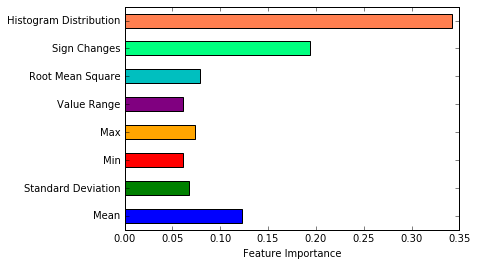

In [153]:
def person_model(find_tree_nums=False):
    #Train a model that recognized people from only walking data
    labels, feats = feature_extraction(accel_data, split_var="PersonID")
    print labels.shape
    print "Features Created"
    train_l, train_f, test_l, test_f = split_train_test_data(labels, feats)
    print "Data Split"
    if find_tree_nums:
        print "Running Optimal Tree Model"
        find_optimal_tree_num(train_l, train_f, test_l, test_f)
    print "Running Random Forest Trials"
    correct, feature_importances = random_forest_model(train_l, train_f, test_l, test_f, n_runs=10, plot=True)
    
person_model(find_tree_nums=False)

In [ ]:
def activity_model1():
    grouped = joint_data.groupby("PersonID")
    for person, features in grouped:
        
        labels, feats = feature_extraction(features, split_var="ActivityID")
        print "Features Created"
        train_l, train_f, test_l, test_f = split_train_test_data(labels, feats)
        print "Data Split"
        print "Running Random Forest Trials"
        correct, feature_importances = random_forest_model(train_l, train_f, test_l, test_f, \
                                                       n_runs=10, plot=True, model_type="Activity")
activity_model1()

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(36432,)
Features Created
Data Split
Running Random Forest Trials
1
Classification Rates: 
Walking: 0.622148167137
Stair Climbing: 0.0
Faking: 0.0
Jogging: 0.0398277717976
Slow Walk: 0.0
Fast Walk: 0.0
Biking: 0.0904872389791
2
Classification Rates: 
Walking: 0.621379133555
Stair Climbing: 0.0
Faking: 0.000868809730669
Jogging: 0.0419806243272
Slow Walk: 0.0
Fast Walk: 0.0
Biking: 0.0904872389791
3
Classification Rates: 
Walking: 0.620866444501
Stair Climbing: 0.0
Faking: 0.0
Jogging: 0.0371367061356
Slow Walk: 0.0
Fast Walk: 0.0
Biking: 0.092807424594
4
Classification Rates: 
Walking: 0.620866444501
Stair Climbing: 0.0
Faking: 0.0
Jogging: 0.0344456404736
Slow Walk: 0.0
Fast Walk: 0.000769230769231
Biking: 0.102088167053
5
Classification Rates: 
Walking: 0.622404511664
Stair Climbing: 0.0
Faking: 0.0
Jogging: 0.0371367061356
Slow Walk: 0.0
Fast Walk: 0.000769230769231
Biking: 0.102088167053
6
Classification Rates: 
Walking: 0.622404511664
Stair Climbing: 0.0
Faking: 0.0
Jogging: 0.039

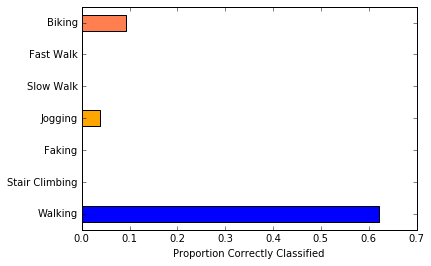

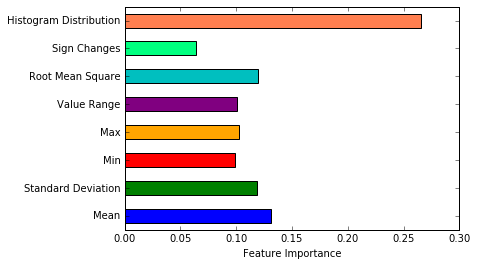

In [159]:
def activity_model2():

    labels, feats = feature_extraction(joint_data, split_var="ActivityID")
    print labels.shape
    print "Features Created"
    train_l, train_f, test_l, test_f = split_train_test_data(labels, feats)
    print "Data Split"
    print "Running Random Forest Trials"
    correct, feature_importances = random_forest_model(train_l, train_f, test_l, test_f, \
                                                       n_runs=10, plot=True, model_type="Activity")
activity_model2()

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Features Created
Data Split
Running Random Forest Trials
0
1
2
3
4
5
6
7
8
9
Proportion correctly classified:  0.209223167719


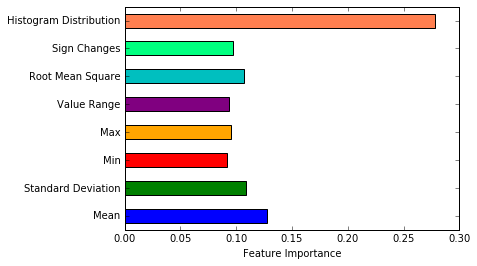

In [127]:
def joint_model():
    labels, feats = feature_extraction(joint_data, split_var="JointID")
    print "Features Created"
    train_l, train_f, test_l, test_f = split_train_test_data(labels, feats)
    print "Data Split"
    print "Running Random Forest Trials"
    correct, feature_importances = random_forest_model(train_l, train_f, test_l, test_f, n_runs=10, plot=True)
joint_model()

### An initial attempt at a KNN Model.  This one doesn't work very well yet

In [ ]:
neighbor_probs = []
for i in xrange(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tr_features, tr_labels)
    knn_labels = knn.predict(te_features)
    neighbor_probs.append(1.-len(np.where(knn_labels != te_labels)[0])/te_labels.shape[0])

plt.plot(range(1, 25), neighbor_probs)

### Function to find example of what an individual's gait should look like

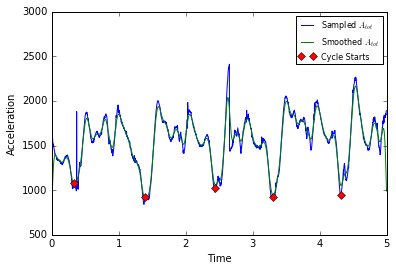

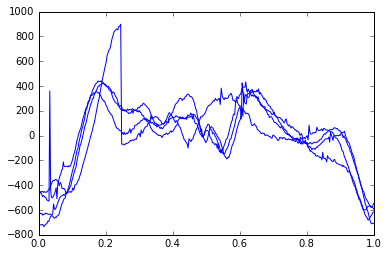

In [136]:
def find_gait_signal_example(data, low_bound, upper_bound, samplerate=400, plot=False):
    #Find a few good examples of a individual's gait to put in my writeup
    #We begin by smoothing the data with a convolution filter
    #sample = accel_data["A_tot"][3216100:3220100].as_matrix()
    #sample = data["A_tot"][low_bound:upper_bound].as_matrix()
    sample = data["A_tot"].as_matrix()[low_bound:upper_bound]
    WINDOW = distributions.norm().pdf(np.linspace(-5,5,samplerate//4))
    WINDOW /= WINDOW.sum()
    conv = np.convolve(sample, WINDOW, mode='same')
    
    #We then find the extrema by finding where there are sign changes in the first derivative
    #Minima correspond to when the sign changes from negative to positive
    diffs =  np.diff(np.sign(np.diff(conv)))
    local_mins = np.where(diffs>0)[0]
    
    #We then look for the local minima that are sufficiently low to qualify as a cycle start
    sample_starts = np.where(sample[local_mins]<sample.min()+(sample.min()/2.5))[0]
    min_indices = local_mins[sample_starts]
    
    #Graph our results to validate our scheme
    if plot==True:
        X = np.linspace(0, len(sample)//samplerate, len(sample))
        plt.plot(X, sample, label="Sampled $A_{tot}$")
        plt.plot(X, conv, label="Smoothed $A_{tot}$")
        plt.plot(X[min_indices], sample[min_indices], 'rD', label="Cycle Starts")
        plt.ylabel("Acceleration")
        plt.xlabel("Time")
        plt.ylim([500,3000])
        plt.legend(loc='best', prop={'size':8})
        plt.show()
    
    sample_plots = [sample, conv, min_indices, samplerate]
    
    #Extract gait signals from this subset
    gait_cycles = []
    for i in xrange(len(min_indices)-1):
        cycle = sample[min_indices[i]:min_indices[i+1]]
        
        if len(cycle)< samplerate/3:
            next
        else:
            gait_cycles.append(cycle)
            if plot==True:
                plt.plot(np.linspace(0,1, len(cycle)), cycle-np.mean(cycle), color='b')
    if plot==True:
        plt.show()
    
    return sample_plots, gait_cycles
    
gaits_1 = find_gait_signal_example(accel_data, 3216100,3218100, plot=True)

In [ ]:
def generate_plots():
    grouped = accel_data.groupby(["PersonID"])
    gait_plots = []
    sample_plots = []
    iters = 0
    for user, features in grouped:
        #Get feature attributes on 3 second samples from each individual
        #We assume no overlap between samples
        sample_rate = features["Samplerate"].as_matrix()[0]
        num_samples = features.count().as_matrix()[0]
        N_4_sec = sample_rate*5
        
        if num_samples < N_4_sec*5:
            next
        
        print iters
        sample_plots.append(find_gait_signal_example(features, num_samples//2, num_samples//2 + N_4_sec, samplerate=sample_rate)[0])
        gait_plots.append(find_gait_signal_example(features, num_samples//2, num_samples//2 + N_4_sec, samplerate=sample_rate)[1])
        iters += 1
        
    colors = ('b', 'g', 'r', '#FFA500','#800080','c',  '#FF7F50')
    """
    for i in xrange(2,5):
        #plt.figure()
        plt.subplot(3, 1, i-1)
        sample, conv, min_indices, rate = sample_plots[i]
        domain = np.linspace(0,2,len(sample))
        plt.ylabel("Acceleration")
        plt.plot(domain, sample)
        plt.plot(domain, conv)
        plt.plot(domain[min_indices], sample[min_indices], 'D')
    """
    
    c_index = 0
    nice = [6,14,17,21,29,30,26]
    nice_plots = [14,29,30,26]
    names = ["Steve","Sally","Suzette","Andrew"]
    for i in nice_plots:
        label_line=True
        for k in gait_plots[i]:
            if label_line:
                plt.plot(np.linspace(0,1,len(k)), k, color = colors[c_index], label=names[c_index])
            else:
                plt.plot(np.linspace(0,1,len(k)), k, color = colors[c_index])
            label_line=False
        c_index+=1
    plt.title("Sample Gait Cycles")
    plt.ylabel("Acceleration")
    plt.legend(loc="best")
    plt.show()
        
        
generate_plots()

In [ ]:
grouped = accel_data.groupby(["PersonID"])
gait_plots = []
sample_plots = []
for user, features in grouped:
    #Get feature attributes on 3 second samples from each individual
    #We assume no overlap between samples
    sample_rate = features["Samplerate"].as_matrix()[0]
    if sample_rate == 50:
        features["A_tot"]
        plt.show()

In [ ]:
nice_plots = [6,14,35,17,21,29,30,26]

** Some failed attempts at finding phases.  An area for further probing and research.**

In [ ]:
def phase_finder(case, local_window=11):
    WINDOW = distributions.norm().pdf(np.linspace(-5,5,75))
    WINDOW /= WINDOW.sum()
    conv = np.convolve(case, WINDOW, mode='same')
    diffs = np.diff(np.sign(np.diff(conv)))
    conv_mins = np.where(diffs > 0)[0] + 1
    conv_maxs = np.where(diffs < 0)[0] + 1
    lo = local_window//2
    ro = (local_window + 1)//2
    mins = [min-lo + case[min-lo:min+ro].argmin() for min in conv_mins]
    maxs = [max-lo + case[max-lo:max+ro].argmax() for max in conv_maxs]
    if mins[0] < maxs[0]:
        mins.pop(0)
    if mins[0] < maxs[0]:
        raise PhaseError("Two max in a row")
    #print case[maxs][0:100]
    yins = np.array([(case[max], case[min]) for max, min in zip(maxs, mins)[1::2]])
    yangs = np.array([(case[max], case[min]) for max, min in zip(maxs, mins)[::2]])
    if yins.mean() < yangs.mean():
        return array([min for max, min in zip(maxs, mins)[1::2]])
    else:
        return array([min for max, min in zip(maxs, mins)[::2]])